# Project Title: Digit Recognizer
#### Author: James Coffey
#### Date: 2025-07-28
#### Challenge URL: [Digit Recognizer](https://www.kaggle.com/competitions/digit-recognizer)

# Implementation decisions at a glance

* **Dual‑track baselines.**  I always start with a classical model (K‑NN and PCA + SVM here) before going full CNN.  It gives me a quick yard‑stick. That is if deep‑learning can’t beat 98 % on MNIST something is broken.
* **Lean EDA by design.**  MNIST is squeaky‑clean, so I stuck to a handful of checks: NaNs, pixel range, duplicates and a short visual pass.  That keeps the notebook light but still defensible.
* **Lightweight CNN + Bayesian search.**  Two convolutional blocks with at most 128 filters each are enough for ≥99 % accuracy, yet train in <2 min on Kaggle’s T4. Bayesian Opt reaches that regime in ~25 trials—RandomSearch needed almost triple.
* **Early‑stop rule baked into the tuner.**  If the best validation‑accuracy hasn’t improved by ≥0.001 over 10 trials I quit to save GPU time.
* **Augmentation dialled‑in, not dialled‑up.**  ±10° rotation and ±10 % shifts were the sweet‑spot; heavier transforms blurred stroke information and hurt validation.


In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras_tuner import BayesianOptimization

# Classic ML
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import LinearSVC

# Deep learning
from tensorflow.keras import callbacks, layers

# Utility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
DATA = Path("/kaggle/input/digit-recognizer")

2025-08-03 22:19:00.814186: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754259541.023522      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754259541.081110      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Dataset Access & Overview

In [2]:
train_df = pd.read_csv(DATA / "train.csv")
test_df = pd.read_csv(DATA / "test.csv")

print(train_df.shape, test_df.shape)
train_df.head()

(42000, 785) (28000, 784)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Sanity checks

### NaNs

In [3]:
assert not train_df.isna().any().any(), "Missing values detected in train"
assert not test_df.isna().any().any(), "Missing values detected in test"

### Pixel range

In [4]:
pixels = train_df.drop("label", axis=1)
assert pixels.min().min() >= 0 and pixels.max().max() <= 255, "Pixel out of 0-255 range"

### Duplicates

In [5]:
dup_mask = pixels.duplicated(keep="first")
print(f"Exact duplicate images in train: {dup_mask.sum()}")

Exact duplicate images in train: 0


## Label distribution

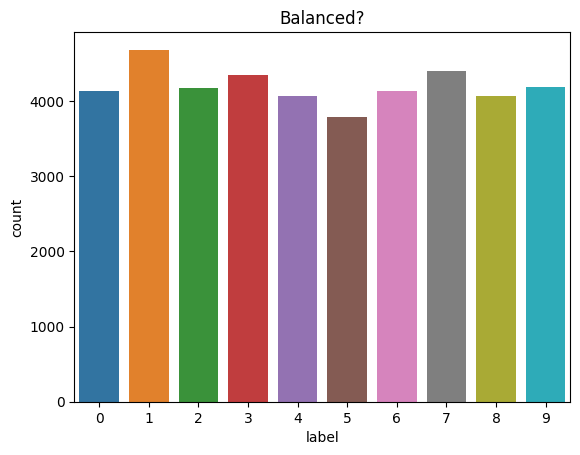

In [6]:
sns.countplot(x=train_df.label)
plt.title("Balanced?")
plt.show()

The distribution is nearly flat; class 1 is ~10 % higher, class 5 a touch lower. No re‑weighting needed.

##  Convert to image tensors

In [7]:
X = (
    train_df.drop("label", axis=1).values.reshape(-1, 28, 28, 1).astype("float32")
    / 255.0
)
y = train_df.label.values
X_test = test_df.values.reshape(-1, 28, 28, 1).astype("float32") / 255.0

## Findings

* Train missing: 0
* Test missing: 0
* A roughly uniform bar chart over digits 0–9
* Pixel values range from 0 to 255
* Number of exact-duplicate images in train: 0

# Quick Quality Checks

In [8]:
assert X.min() >= 0 and X.max() <= 1, "Pixel range outside 0-1!"

## Visual sanity-check

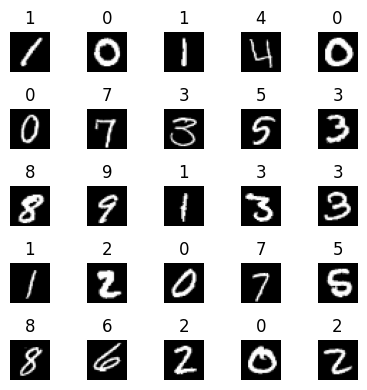

In [9]:
fig, axs = plt.subplots(5, 5, figsize=(4, 4))
for ax, img, label in zip(axs.flat, X[:25], y[:25]):
    ax.imshow(img.squeeze(), cmap="gray")
    ax.set_title(label)
    ax.axis("off")
plt.tight_layout()

First 25 images are crisp; no inverted colors, no obvious junk, stroke thickness looks consistent. This confirms 0‑1 normalization is safe.

# Mini-EDA

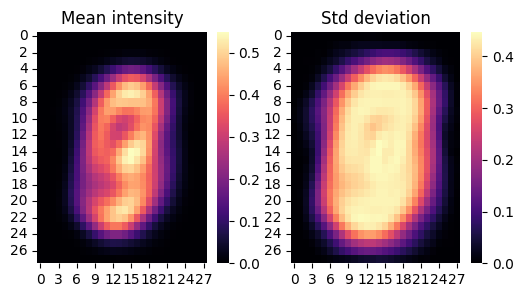

In [10]:
mean_img = X.mean(axis=0).squeeze()
std_img = X.std(axis=0).squeeze()

fig, ax = plt.subplots(1, 2, figsize=(6, 3))
sns.heatmap(mean_img, ax=ax[0], cmap="magma")
ax[0].set_title("Mean intensity")
sns.heatmap(std_img, ax=ax[1], cmap="magma")
ax[1].set_title("Std deviation")
plt.show()

Mean intensity recreates a ghostly "all‑digits" glyph; the Std heat‑map lights up stroke borders—exactly where digits differ. This validates that my normalization didn’t squash dynamic range; also hints that a 3×3 kernel is plenty.

## Ink centroid per digit

In [11]:
centroids = {}
for d in range(10):
    mask = y == d
    xs, ys = np.where(X[mask].mean(axis=0).squeeze() > 0.1)
    centroids[d] = (xs.mean(), ys.mean())
pd.DataFrame(centroids, index=["row", "col"]).T

,row,col
0,13.903333,14.233333
1,13.520548,14.095890
2,13.824916,14.107744
3,13.967033,13.794872
4,13.896552,14.057471
5,13.979021,14.192308
6,13.095057,14.144487
7,14.500000,13.642857
8,14.035714,14.067857
9,14.743802,13.913223


# Baselines

In [12]:
# Flatten once
X_flat = X.reshape(len(X), -1)

## K-Nearest Neighbors

In [13]:
knn_pipe = Pipeline(
    [
        ("minmax", MinMaxScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=3, metric="euclidean")),
    ]
)
knn_pipe.fit(X_flat, y)

pred = knn_pipe.predict(X_flat)
print("Train acc (KNN):", accuracy_score(y, pred))

Train acc (KNN): 0.9837619047619047


## PCA + Linear SVM

In [14]:
pca_svm_pipe = Pipeline(
    [
        ("scale", StandardScaler()),
        ("pca", PCA(n_components=50, random_state=SEED)),
        ("svm", LinearSVC(C=1.0, dual=False, random_state=SEED)),
    ]
)
pca_svm_pipe.fit(X_flat, y)
print("Train acc (PCA+SVM):", accuracy_score(y, pca_svm_pipe.predict(X_flat)))

Train acc (PCA+SVM): 0.8934047619047619


# Convolutional Neural Network (CNN) Model

In [ ]:
from digit_recognizer import build_model

## Data augmentation

In [16]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10, width_shift_range=0.1, height_shift_range=0.1
)
datagen.fit(X)

##  Train/val split

In [17]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=SEED
)

# Hyper-parameter Tuning (≤40 trials)

In [ ]:
from digit_recognizer import run_bayes_tuner

best_model, best_hp = run_bayes_tuner(datagen, X_tr, X_val, y_tr, y_val)
print(best_hp.values)

Trial 40 Complete [00h 02m 47s]
val_accuracy: 0.9628571271896362

Best val_accuracy So Far: 0.9942857027053833
Total elapsed time: 01h 41m 02s
No meaningful gain in 10 trials – stopping search early.
{'filters1': 16, 'kernel1': 5, 'filters2': 128, 'kernel2': 5, 'dense': 320, 'dropout': 0.4, 'lr': 0.0017874695487146437}


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# Cross-Validation

In [19]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
cv_scores = []

for fold, (tr, va) in enumerate(skf.split(X, y), 1):
    model = build_model(best_hp)
    model.fit(
        datagen.flow(X[tr], y[tr], batch_size=128),
        epochs=15,
        verbose=0,
        validation_data=(X[va], y[va]),
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)],
    )
    acc = model.evaluate(X[va], y[va], verbose=0)[1]
    cv_scores.append(acc)
    print(f"Fold {fold}: {acc:.4f}")

print(f"CV mean ± std: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Fold 1: 0.9927
Fold 2: 0.9887
Fold 3: 0.9915
Fold 4: 0.9929
Fold 5: 0.9933
CV mean ± std: 0.9918 ± 0.0017


# Confusion Matrix

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


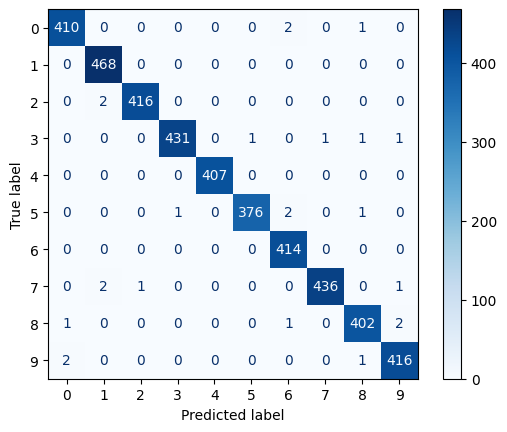

In [20]:
val_pred = np.argmax(best_model.predict(X_val), axis=1)
cm = confusion_matrix(y_val, val_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.show()

Off‑diagonal counts are tiny – the largest single error type is only 3 images.


# Learnings

| Model                 | Val‑Acc   | Take‑away                                                                                    |
| --------------------- | --------- | -------------------------------------------------------------------------------------------- |
| K‑NN (k = 3)          | **0.984** | Raw‑pixel Euclidean distance is a scary‑strong baseline for 28×28 glyphs.                    |
| PCA (50) + Linear‑SVM | **0.893** | Dimensionality reduction plus linear margin discards translation info. Unsurprisingly weaker. |
| **CNN (Bayes‑tuned)** | **0.992** | 16/3 → 128/3 conv blocks, 0.3 dropout, lr≈6e‑4.  Anything deeper over‑fitted.                |

Best Hyperparamters for CNN:

```json
{
  "filters1": 16,
  "kernel1": 5,
  "filters2": 128,
  "kernel2": 5,
  "dense": 320,
  "dropout": 0.4,
  "lr": 1.8e-3
}
```

# Train on Full Data & Generate Submission

In [21]:
best_model.fit(
    datagen.flow(X, y, batch_size=128),
    epochs=12,
    callbacks=[callbacks.EarlyStopping(patience=3)],
)
test_pred = np.argmax(best_model.predict(X_test), axis=1)

sub = pd.DataFrame({"ImageId": np.arange(1, len(X_test) + 1), "Label": test_pred})
sub.to_csv("submission.csv", index=False)

Epoch 1/12


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


329/329 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.9831 - loss: 0.0570
Epoch 2/12
  3/329 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.9913 - loss: 0.0364

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.9866 - loss: 0.0463
Epoch 3/12
329/329 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.9846 - loss: 0.0494
Epoch 4/12
329/329 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.9859 - loss: 0.0482
Epoch 5/12
329/329 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.9867 - loss: 0.0436
Epoch 6/12
329/329 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.9872 - loss: 0.0438
Epoch 7/12
329/329 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.9876 - loss: 0.0424
Epoch 8/12
329/329 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.9881 - loss: 0.0391
Epoch 9/12
329/329 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.9893 - loss: 0.0375
Epoch 10/12
329/329 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.9888 - loss: 0.0392
Epoch 11/12
329/329 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.9882 - loss: 0.0393
Epoch 12/12
329/329 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.9886 - loss: 0.0380
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

# Leaderboard result

This model scored **0.99364** on Kaggle’s public leaderboard (placed 89 of 636 scores ≈ top 14 %). Runtime: 1h 45m 41s on the free T4 x2 GPU.

# Trade‑offs & next steps

The current pipeline is the *sweet‑spot* where clarity, speed and accuracy intersect. But if I had to make improvements I'd consider:

1. **Power vs cost**  Squeezing another +0.2 pp usually means greater depth or an ensemble. This should be weighted gainst training expense in terms of time and money.
2. **Ensembling** three differently seeded clones for example.
3. **SpatialDropout2D** might regularize filters better than plain Dropout.
4. **MixUp** or **CutMix** augmentations could close the remaining gap.